# IDA FOR ALL RESPONSES
___
### Includes code which builds figures used in-paper or to explore relationships in data
##### <font color = 'blue'> Created by Max Gregg. Parts of the code seen here were produced in-part or reconstructed using ChatGPT 4o or Claude 3.5 Sonnet. 

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics import confusion_matrix
from matplotlib.cm import viridis


plt.rcParams['font.family'] = 'Times New Roman'

In [3]:


models_df = pd.read_csv('models_prg.csv')

# df_sonnet35 = pd.read_csv("df_sonnet35_20240807-1451.csv")
# df_sonnet = pd.read_csv("df_sonnet_20240807-1218.csv")
# df_haiku = pd.read_csv("df_haiku_20240807-0050.csv")
# df_4o_mini = pd.read_csv("df_4o_mini_20240806-2238.csv")
# df_4o_lowtemp = pd.read_csv("df_4o_lowtemp_aug6.csv")
# df_4o_hightemp = pd.read_csv("df_4o_hightemp_aug5.csv")
# df_4o = pd.read_csv("df_4o_aug5.csv")
# df_35_resp = pd.read_csv("df_35_resp_aug5.csv")
# df_assistant_4o_optimizedbook = pd.read_csv("df_assistant_4o_optimizedbook_20240808-2354.csv")
# df_assistant_4o_mini_fullbook = pd.read_csv("df_assistant_4o_mini_fullbook_20240808-0010.csv")
# df_opus = pd.read_csv("df_opus_20240807-1751.csv")





In [4]:
# models_df.count().isna()

# models_df.columns

# models_df['model'].unique()

<Figure size 1400x800 with 0 Axes>

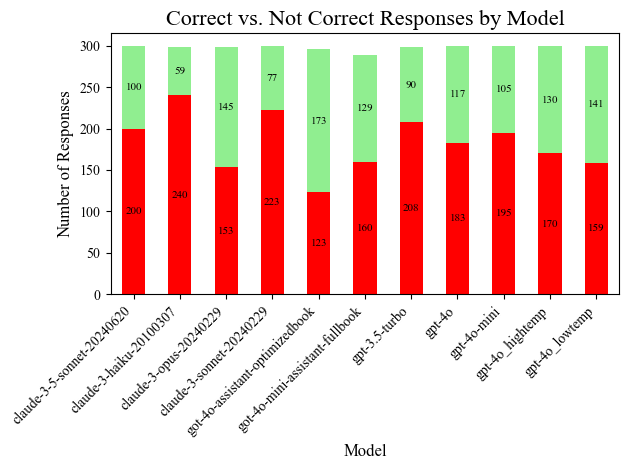

In [5]:
# Count the occurrences of 'C' and 'NC' for each model
correct_counts = models_df.groupby(['model', 'response correct?']).size().unstack(fill_value=0)

# Diagnostic print
# print("\nShape of correct_counts:", correct_counts.shape)
# print("Columns in correct_counts:", correct_counts.columns)
# print("Index in correct_counts:", correct_counts.index)

# Ensure both 'C' and 'NC' columns exist
if 'C' not in correct_counts.columns:
    correct_counts['C'] = 0
if 'NC' not in correct_counts.columns:
    correct_counts['NC'] = 0

# Reorder columns to ensure 'NC' comes before 'C'
correct_counts = correct_counts[['NC', 'C']]

# Check if the DataFrame is empty
if correct_counts.empty:
    print("The correct_counts DataFrame is empty. Cannot create the plot.")
else:
    # Expand the graph for better readability
    plt.figure(figsize=(14, 8))

    # Plot the distribution of correct vs. not correct responses
    ax = correct_counts.plot(kind='bar', stacked=True, color=['red', 'lightgreen'])

    plt.title('Correct vs. Not Correct Responses by Model', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Number of Responses', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend().remove()

    # Add value labels on the bars
    for c in ax.containers:
        ax.bar_label(c, label_type='center', fontsize=8)

    plt.tight_layout()
    plt.show()

In [5]:
## average of all models
(100+59+145+77+173+129+90+117+105+130+141)/(300*11)

# 300*.3836363636363636

105/300

0.35

In [6]:
##### Define a mapping for more readable names as needed
name_mapping = {
    'assessment_35turbo_Prediction': ' GPT 3.5 Turbo',
    'assessment_4omini_Prediction': 'GPT 4.0 Mini',
    'assessment_4o_Prediction': 'GPT 4.0',
    'assessment_4o_hightemp_Prediction': 'GPT 4.0 High Temp',
    'assessment_4o_lowtemp_Prediction': 'GPT 4.0 Low Temp',
    'haiku_assessment_Prediction': 'GPT Haiku',
    'sonnet_assessment_Prediction': 'Claude Sonnet',
    'sonnet35_assessment_Prediction': 'Claude Sonnet 3.5',
    'opus_assessment_Prediction': 'Claude Opus',
    'gpt_assis_4omini_assessment_Prediction': 'GPT Assistant Mini, Full Book',
    'gpt_assis_optimizedbook_assessment_Prediction': 'GPT Optimized Book'
}



In [7]:
false_positives = {}
false_negatives = {}

for col in models_df.columns:
    if 'Prediction' in col:
        # False Positives: Predicted "True" but was "NC"
        fp_count = models_df.apply(lambda row: row[col] == 'True' and row['response correct?'] == 'NC', axis=1).sum()
        false_positives[col.split('_Prediction')[0]] = fp_count
        
        # False Negatives: Predicted "False" but was "C"
        fn_count = models_df.apply(lambda row: row[col] == 'False' and row['response correct?'] == 'C', axis=1).sum()
        false_negatives[col.split('_Prediction')[0]] = fn_count

# Convert to DataFrames for easier analysis
false_positives_df = pd.DataFrame.from_dict(false_positives, orient='index', columns=['False_Positives'])
false_negatives_df = pd.DataFrame.from_dict(false_negatives, orient='index', columns=['False_Negatives'])

False positives occur when a model predicts "True" but the actual result is "NC". False negatives occur when a model predicts "False" but the actual result is "C".

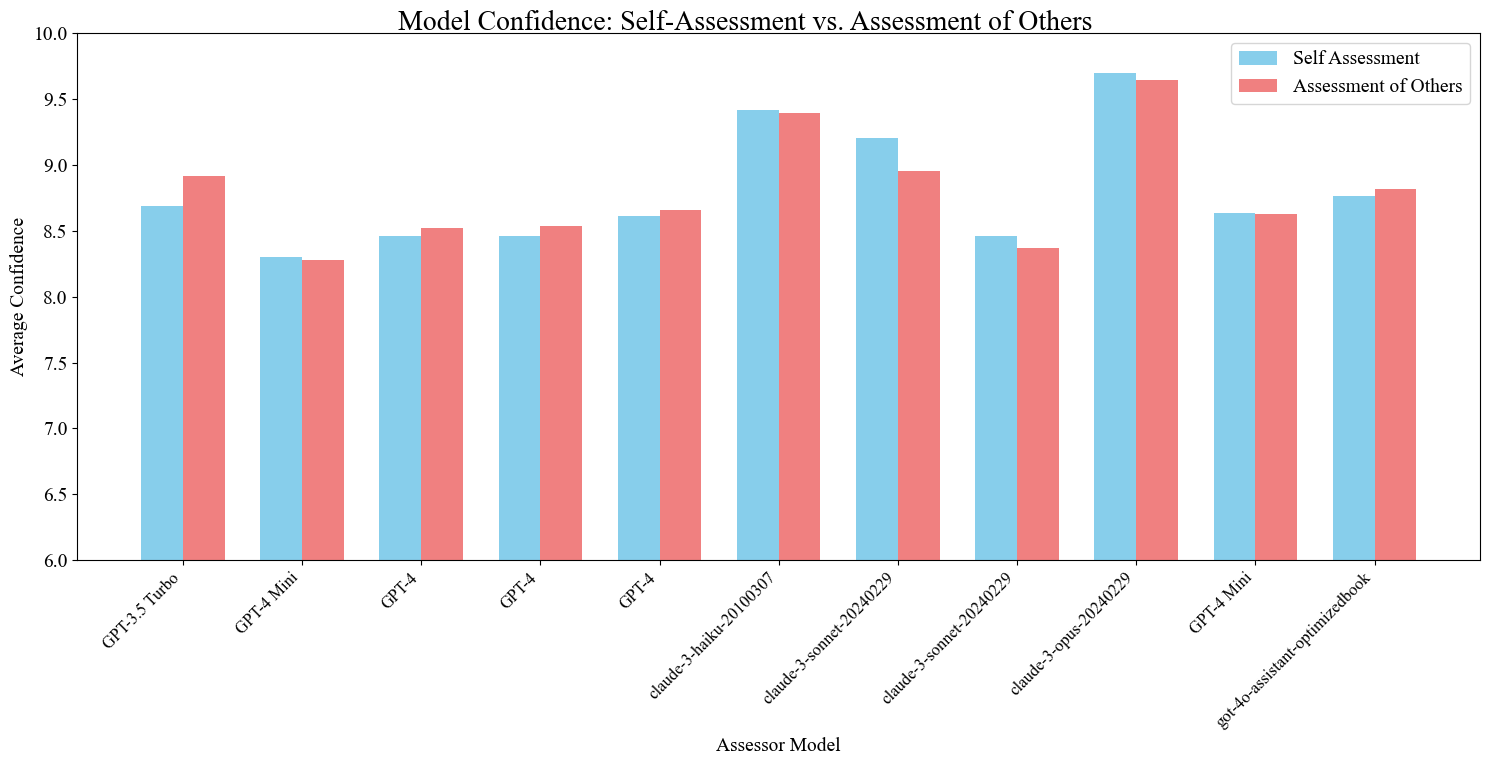


Detailed Results:
                      assessor  self_confidence  others_confidence  difference
                 gpt-3.5-turbo         8.686667           8.912333   -0.225667
                   gpt-4o-mini         8.300000           8.281333    0.018667
                        gpt-4o         8.463333           8.521000   -0.057667
                        gpt-4o         8.463333           8.538667   -0.075333
                        gpt-4o         8.610000           8.654333   -0.044333
       claude-3-haiku-20100307         9.416667           9.393667    0.023000
      claude-3-sonnet-20240229         9.200000           8.954667    0.245333
      claude-3-sonnet-20240229         8.460000           8.367333    0.092667
        claude-3-opus-20240229         9.700000           9.641667    0.058333
                   gpt-4o-mini         8.636667           8.630333    0.006333
got-4o-assistant-optimizedbook         8.766667           8.814381   -0.047715


In [8]:
###############################
# SECTION 1: Helper Functions #
###############################

def extract_confidence(text):  # changed
    """Extract numeric confidence value after 'Confidence:' string"""
    try:
        match = re.search(r'Confidence:\s*(\d+(?:\.\d*)?)', str(text))
        return float(match.group(1)) if match else np.nan
    except:
        return np.nan

def map_assessment_to_model(assessment_col):
    """Map assessment column names to their corresponding model names"""
    # Remove assessment prefix/suffix and convert to standard model name format
    model_map = {
        '35turbo': 'gpt-3.5-turbo',
        '4omini': 'gpt-4o-mini',
        '4o': 'gpt-4o',
        '4o_hightemp': 'gpt-4o_hightemp',
        '4o_lowtemp': 'gpt-4o_lowtemp',
        'haiku': 'claude-3-haiku-20100307',
        'sonnet': 'claude-3-sonnet-20240229',
        'sonnet35': 'claude-3-5-sonnet-20240620',
        'opus': 'claude-3-opus-20240229',
        'gpt_assis_4omini': 'got-4o-mini-assistant-fullbook',
        'gpt_assis_optimizedbook': 'got-4o-assistant-optimizedbook'
    }
    
    for key, value in model_map.items():
        if key in assessment_col:
            return value
    return None

##################################
# SECTION 2: Analysis Function   #
##################################

def analyze_self_vs_others_confidence(df, assessment_columns):
    """Calculate average confidence for self-assessment vs other-assessment"""
    results = []
    
    for assessor_col in assessment_columns:
        # Get assessor model name
        assessor_model = map_assessment_to_model(assessor_col)
        if not assessor_model:
            continue
            
        # Extract confidence values (using new regex-based function)
        confidences = df[assessor_col].apply(extract_confidence)  # changed
        
        # Calculate average confidence for self vs others
        self_conf = confidences[df['model'] == assessor_model].mean()
        others_conf = confidences[df['model'] != assessor_model].mean()
        
        # Store results
        results.append({
            'assessor': assessor_model,
            'self_confidence': self_conf,
            'others_confidence': others_conf,
            'difference': self_conf - others_conf
        })
    
    return pd.DataFrame(results)

#############################
# SECTION 3: Visualization #
#############################

# Example name_mapping dictionary if you need custom labels on the x-axis
name_mapping = {          # changed (if needed)
    'gpt-3.5-turbo': 'GPT-3.5 Turbo',
    'gpt-4o-mini': 'GPT-4 Mini',
    'gpt-4o': 'GPT-4',
    'gpt-4o_hightemp': 'GPT-4 HighTemp',
    'gpt-4o_lowtemp': 'GPT-4 LowTemp',
    'claude-3-haiku': 'Claude-3 Haiku',
    # etc...
}

def plot_self_vs_others_confidence(results_df):
    """Create grouped bar plot comparing self vs others confidence"""
    plt.figure(figsize=(15, 8))
    
    # Set up bar positions
    x = np.arange(len(results_df))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, results_df['self_confidence'], width, 
            label='Self Assessment', color='skyblue')
    plt.bar(x + width/2, results_df['others_confidence'], width,
            label='Assessment of Others', color='lightcoral')
    
    # Customize plot
    plt.suptitle('Model Confidence: Self-Assessment vs. Assessment of Others', 
                y=0.95, fontsize=20)
    
    plt.xlabel('Assessor Model', fontsize=14)
    plt.ylabel('Average Confidence', fontsize=14)
    
    # Customize x-axis using name_mapping if desired
    plt.xticks(x, [
        name_mapping.get(name, name)  # changed to use your custom dict if needed
        for name in results_df['assessor']
    ], rotation=45, ha='right', fontsize=12)
    
    plt.yticks(fontsize=14)
    
    # Set y-axis range
    plt.ylim(6, 10)
    
    # Add legend
    plt.legend(fontsize=14)
    
    plt.tight_layout()
    return plt.gcf()

##############################
# SECTION 4: Main Execution #
##############################

# Define assessment columns
assessment_columns = [
    'assessment_35turbo', 'assessment_4omini', 'assessment_4o',
    'assessment_4o_hightemp', 'assessment_4o_lowtemp', 'haiku_assessment',
    'sonnet_assessment', 'sonnet35_assessment', 'opus_assessment',
    'gpt_assis_4omini_assessment', 'gpt_assis_optimizedbook_assessment'
]

# Run analysis
results = analyze_self_vs_others_confidence(models_df, assessment_columns)

# Plot
plot_self_vs_others_confidence(results)
plt.show()

# Print detailed statistics
print("\nDetailed Results:")
print(results.to_string(index=False))


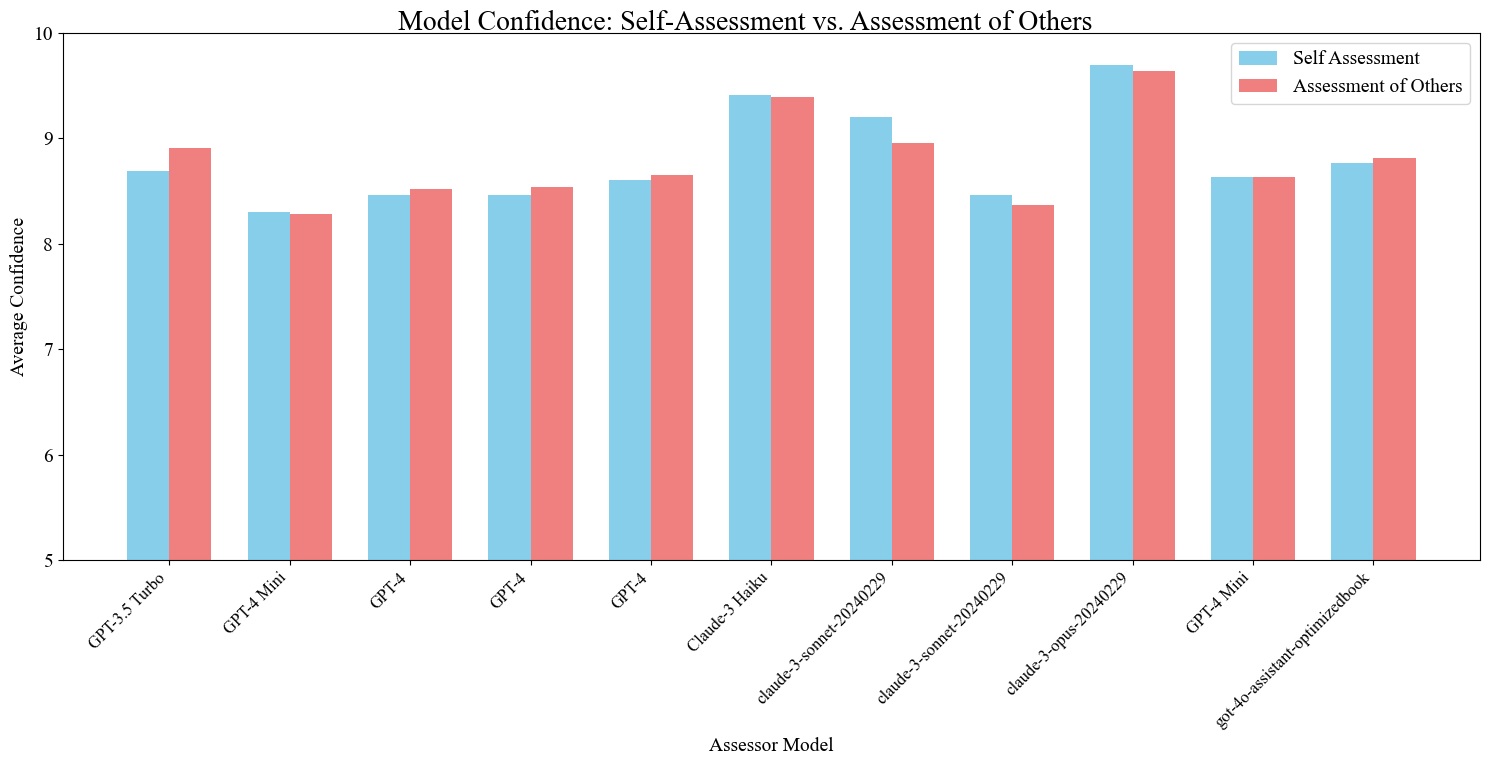


Detailed Results:
                      assessor  self_confidence  others_confidence  difference
                 gpt-3.5-turbo         8.686667           8.912333   -0.225667
                   gpt-4o-mini         8.300000           8.281333    0.018667
                        gpt-4o         8.463333           8.521000   -0.057667
                        gpt-4o         8.463333           8.538667   -0.075333
                        gpt-4o         8.610000           8.654333   -0.044333
       claude-3-haiku-20100307         9.416667           9.393667    0.023000
      claude-3-sonnet-20240229         9.200000           8.954667    0.245333
      claude-3-sonnet-20240229         8.460000           8.367333    0.092667
        claude-3-opus-20240229         9.700000           9.641667    0.058333
                   gpt-4o-mini         8.636667           8.630333    0.006333
got-4o-assistant-optimizedbook         8.766667           8.814381   -0.047715


In [9]:
# SECTION 1: Helper Functions

def map_assessment_to_model(assessment_col):
    """Map assessment column names to their corresponding model names"""
    # Remove assessment prefix/suffix and convert to standard model name format
    model_map = {
        '35turbo': 'gpt-3.5-turbo',
        '4omini': 'gpt-4o-mini',
        '4o': 'gpt-4o',
        '4o_hightemp': 'gpt-4o_hightemp',
        '4o_lowtemp': 'gpt-4o_lowtemp',
        'haiku': 'claude-3-haiku-20100307',
        'sonnet': 'claude-3-sonnet-20240229',
        'sonnet35': 'claude-3-5-sonnet-20240620',
        'opus': 'claude-3-opus-20240229',
        'gpt_assis_4omini': 'got-4o-mini-assistant-fullbook',
        'gpt_assis_optimizedbook': 'got-4o-assistant-optimizedbook'
    }
    
    for key, value in model_map.items():
        if key in assessment_col:
            return value
    return None

# SECTION 2: Analysis Function
def analyze_self_vs_others_confidence(df, assessment_columns):
    """Calculate average confidence for self-assessment vs other-assessment"""
    results = []
    
    for assessor_col in assessment_columns:
        # Get assessor model name
        assessor_model = map_assessment_to_model(assessor_col)
        if not assessor_model:
            continue
            
        # Extract confidence values
        confidences = df[assessor_col].apply(extract_confidence)
        
        # Calculate average confidence for self vs others
        self_conf = confidences[df['model'] == assessor_model].mean()
        others_conf = confidences[df['model'] != assessor_model].mean()
        
        # Store results
        results.append({
            'assessor': assessor_model,
            'self_confidence': self_conf,
            'others_confidence': others_conf,
            'difference': self_conf - others_conf
        })
    
    return pd.DataFrame(results)

# SECTION 3: Visualization
def plot_self_vs_others_confidence(results_df):
    """Create grouped bar plot comparing self vs others confidence"""
    plt.figure(figsize=(15, 8))
    
    # Set up bar positions
    x = np.arange(len(results_df))
    width = 0.35
    
    # Create bars
    plt.bar(x - width/2, results_df['self_confidence'], width, 
            label='Self Assessment', color='skyblue')
    plt.bar(x + width/2, results_df['others_confidence'], width,
            label='Assessment of Others', color='lightcoral')
    
    # Customize plot
    plt.suptitle('Model Confidence: Self-Assessment vs. Assessment of Others', 
                y=0.95, fontsize=20)
    
    plt.xlabel('Assessor Model', fontsize=14)
    plt.ylabel('Average Confidence', fontsize=14)
    
    # Customize x-axis
    plt.xticks(x, [name_mapping.get(name.split('-20')[0], name) for name in results_df['assessor']], 
           rotation=45, ha='right', fontsize=12)    
    plt.yticks(fontsize=14)
    
    # Set y-axis range
    plt.ylim(5, 10)
    
    # Add legend
    plt.legend(fontsize=14)
    
    plt.tight_layout()
    return plt.gcf()

# SECTION 4: Main Execution
# Define assessment columns
assessment_columns = [
    'assessment_35turbo', 'assessment_4omini', 'assessment_4o',
    'assessment_4o_hightemp', 'assessment_4o_lowtemp', 'haiku_assessment',
    'sonnet_assessment', 'sonnet35_assessment', 'opus_assessment',
    'gpt_assis_4omini_assessment', 'gpt_assis_optimizedbook_assessment'
]

# Run analysis and create plot
results = analyze_self_vs_others_confidence(models_df, assessment_columns)
plot_self_vs_others_confidence(results)
plt.show()

# Print detailed statistics
print("\nDetailed Results:")
print(results.to_string(index=False))

In [10]:
import re

# Define the regular expression for the expected format
pattern = r'^Prediction:\s(True|False),\sConfidence:\s\d+\.?$'

# Initialize a list to hold DataFrames of invalid entries
invalid_entries_list = []

# Check each assessment column for invalid entries
for col in ['assessment_35turbo', 'assessment_4omini', 'assessment_4o', 
            'assessment_4o_hightemp', 'assessment_4o_lowtemp', 'haiku_assessment',
            'sonnet_assessment', 'sonnet35_assessment', 'opus_assessment',
            'gpt_assis_4omini_assessment', 'gpt_assis_optimizedbook_assessment']:
    
    # Use a boolean mask to find rows where the format does not match
    invalid_mask = ~models_df[col].apply(lambda x: bool(re.match(pattern, str(x))))
    
    # Append the invalid rows to the list
    if invalid_mask.any():  # Only add if there are invalid entries
        invalid_entries_list.append(models_df[invalid_mask][['question_number', 'qualifier_year', col]])

# Concatenate all the invalid entries into a single DataFrame
if invalid_entries_list:
    invalid_entries = pd.concat(invalid_entries_list, ignore_index=True)
else:
    invalid_entries = pd.DataFrame(columns=['question_number', 'qualifier_year'] + ['Column'])

# Display the rows with invalid entries
invalid_entries_display = invalid_entries
invalid_entries_display["assessment_4o_hightemp"]


0             “Prediction: True, Confidence: 9.”
1     ```\nPrediction: False, Confidence: 9\n```
2                                            NaN
3                                            NaN
4                                            NaN
                         ...                    
72                                           NaN
73                                           NaN
74                                           NaN
75                                           NaN
76                                           NaN
Name: assessment_4o_hightemp, Length: 77, dtype: object

In [11]:
assess_df = models_df[['assessment_35turbo', 'assessment_4omini', 'assessment_4o', 
            'assessment_4o_hightemp', 'assessment_4o_lowtemp', 'haiku_assessment',
            'sonnet_assessment', 'sonnet35_assessment', 'opus_assessment',
            'gpt_assis_4omini_assessment', 'gpt_assis_optimizedbook_assessment']]

readable_names = {
    'assessment_35turbo': 'GPT-3.5 Turbo',
    'assessment_4omini': 'GPT-4o Mini',
    'assessment_4o': 'GPT-4o',
    'assessment_4o_hightemp': 'GPT-4o High Temp',
    'assessment_4o_lowtemp': 'GPT-4o Low Temp',
    'haiku_assessment': 'Claude Haiku',
    'sonnet_assessment': 'Claude Sonnet',
    'sonnet35_assessment': 'Claude 3.5 Sonnet',
    'opus_assessment': 'Claude Opus',
    'gpt_assis_4omini_assessment': 'GPT-4o Mini Assistant, Full Textbook',
    'gpt_assis_optimizedbook_assessment': 'GPT-4o Optimized Book'
}

In [12]:
# Function to create confusion matrix
def create_confusion_matrix(true_labels, pred_labels):
    return confusion_matrix(true_labels, pred_labels, labels=['C', 'NC'])

# Dictionary to store confusion matrices
confusion_matrices = {}

# Create confusion matrices for each model
for col in assess_df.columns:
    if 'Prediction' in col:
        model_name = col.split('_Prediction')[0]
        true_labels = models_df['response correct?']
        pred_labels = models_df[col].map({'True': 'C', 'False': 'NC'})
        confusion_matrices[model_name] = create_confusion_matrix(true_labels, pred_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NC', 'C'],
                yticklabels=['NC', 'C'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for each model
for model_name, cm in confusion_matrices.items():
    plot_confusion_matrix(cm, model_name)


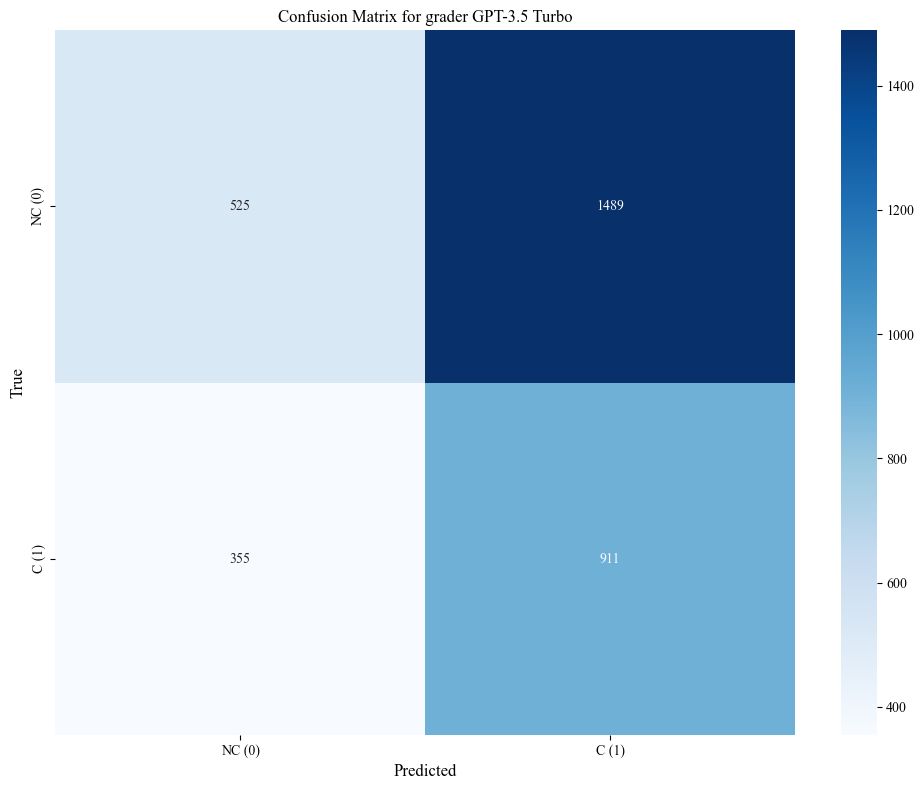


Confusion Matrix for GPT-3.5 Turbo:
[[ 525 1489]
 [ 355  911]]
True Negatives (NC predicted as NC): 525
False Positives (NC predicted as C): 1489
False Negatives (C predicted as NC): 355
True Positives (C predicted as C): 911


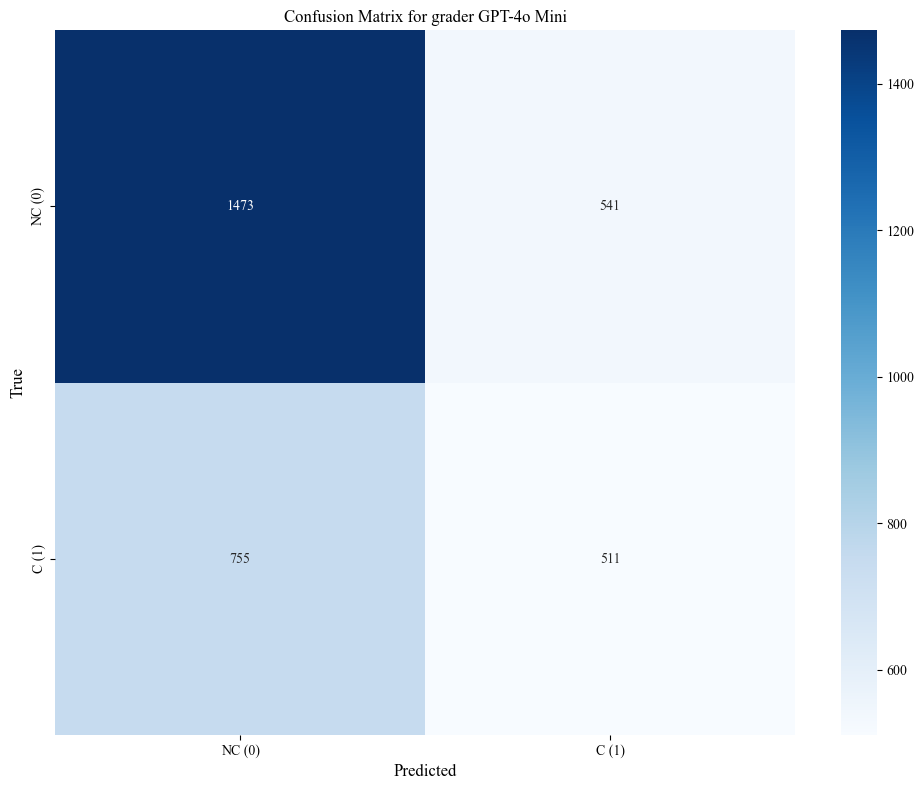


Confusion Matrix for GPT-4o Mini:
[[1473  541]
 [ 755  511]]
True Negatives (NC predicted as NC): 1473
False Positives (NC predicted as C): 541
False Negatives (C predicted as NC): 755
True Positives (C predicted as C): 511


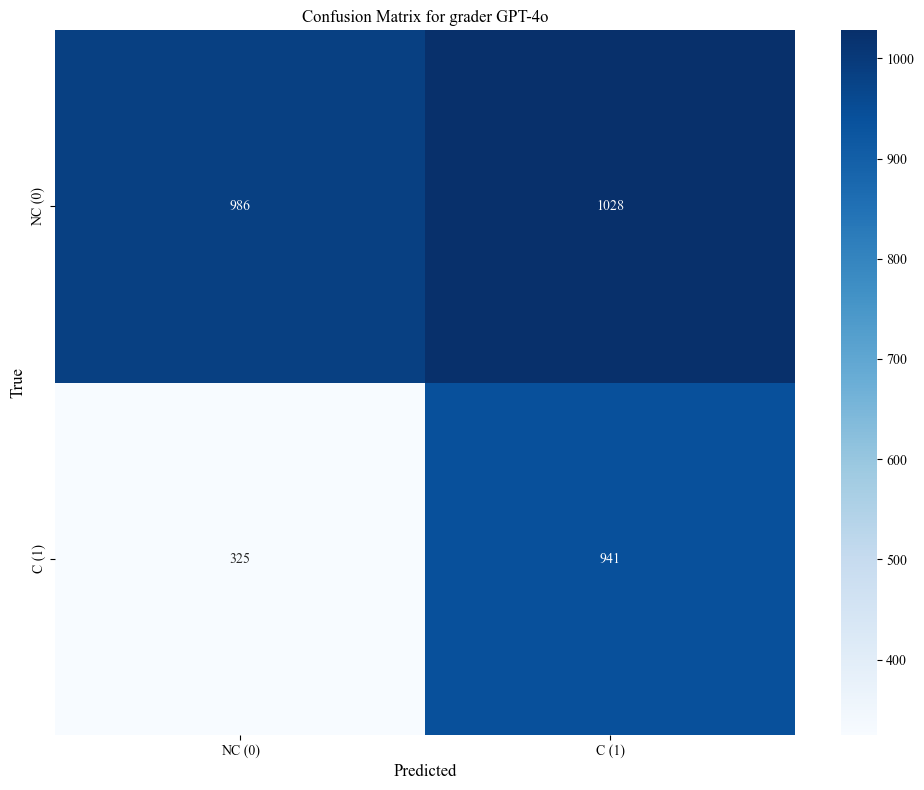


Confusion Matrix for GPT-4o:
[[ 986 1028]
 [ 325  941]]
True Negatives (NC predicted as NC): 986
False Positives (NC predicted as C): 1028
False Negatives (C predicted as NC): 325
True Positives (C predicted as C): 941


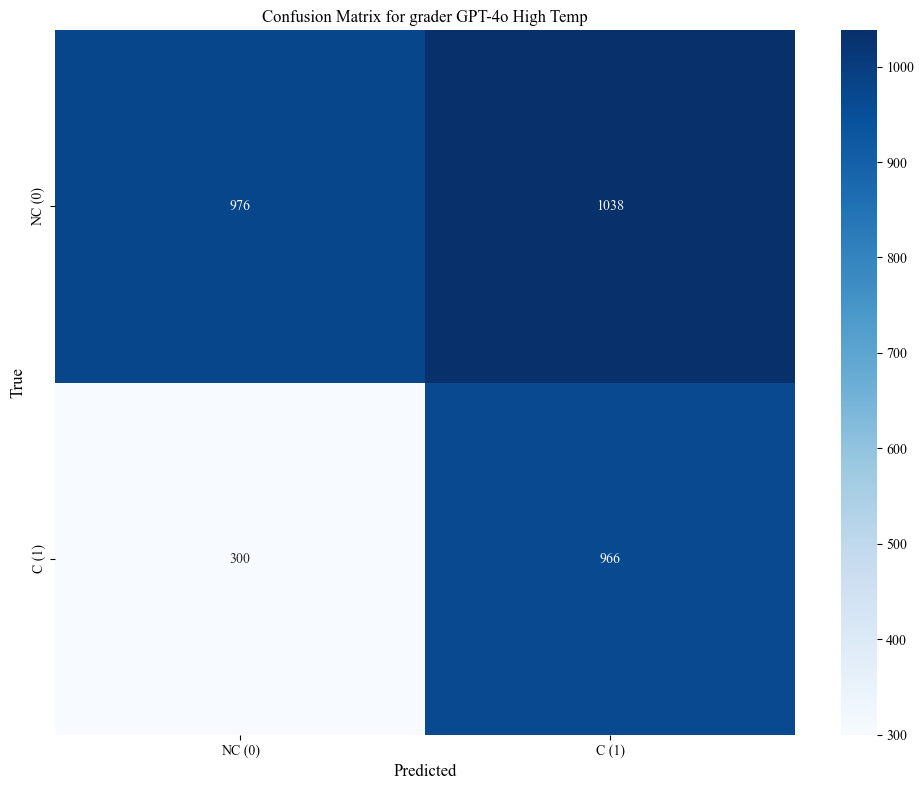


Confusion Matrix for GPT-4o High Temp:
[[ 976 1038]
 [ 300  966]]
True Negatives (NC predicted as NC): 976
False Positives (NC predicted as C): 1038
False Negatives (C predicted as NC): 300
True Positives (C predicted as C): 966


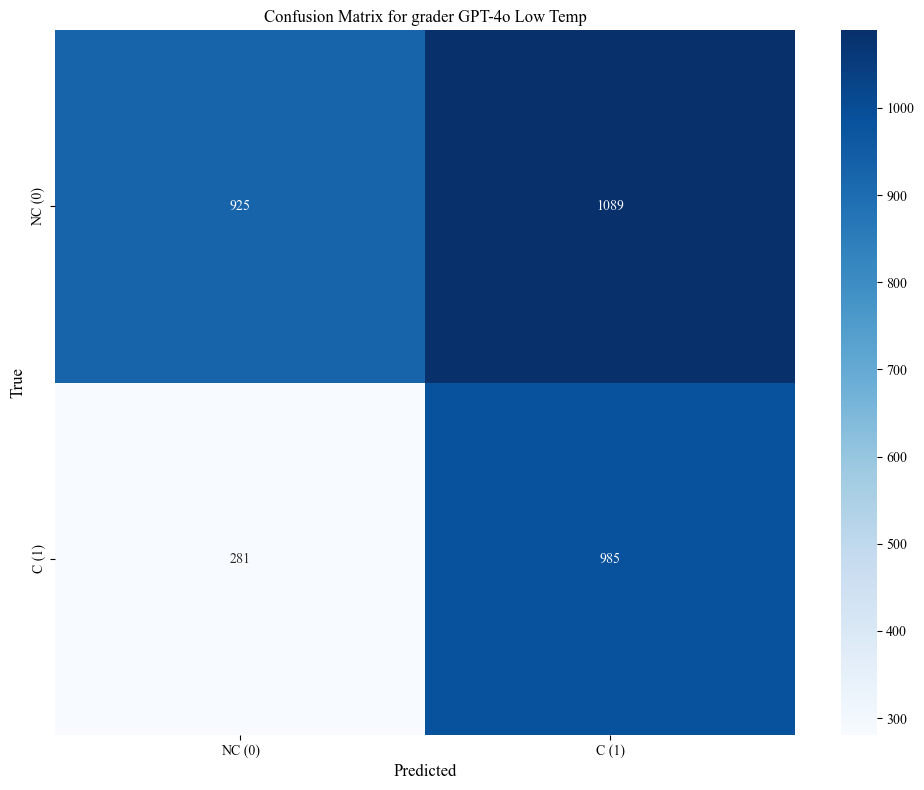


Confusion Matrix for GPT-4o Low Temp:
[[ 925 1089]
 [ 281  985]]
True Negatives (NC predicted as NC): 925
False Positives (NC predicted as C): 1089
False Negatives (C predicted as NC): 281
True Positives (C predicted as C): 985


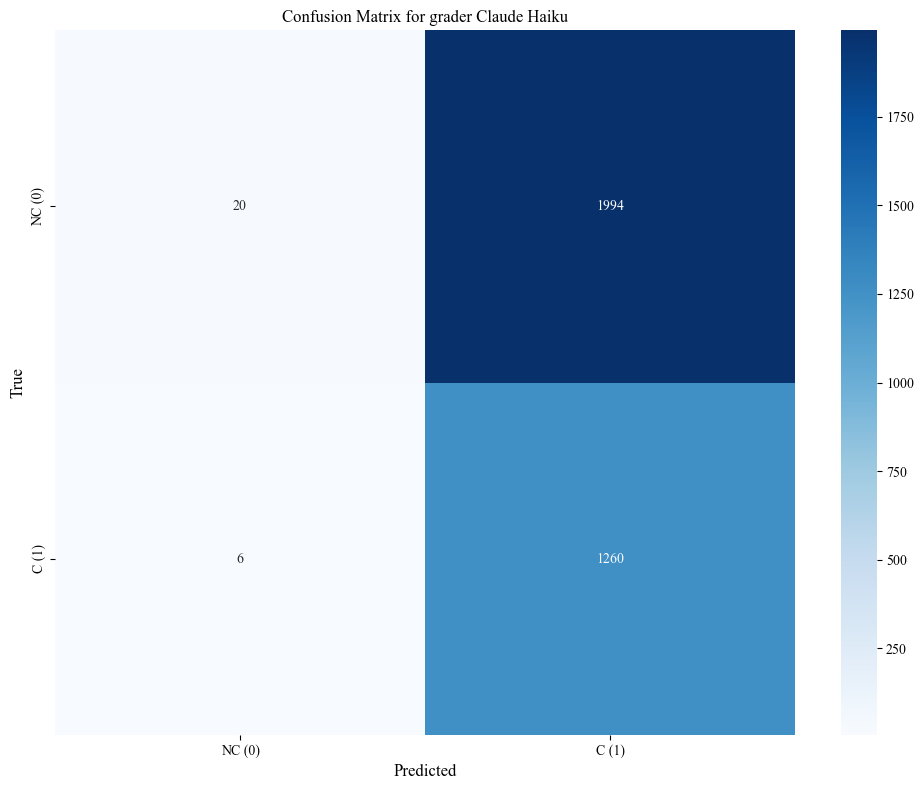


Confusion Matrix for Claude Haiku:
[[  20 1994]
 [   6 1260]]
True Negatives (NC predicted as NC): 20
False Positives (NC predicted as C): 1994
False Negatives (C predicted as NC): 6
True Positives (C predicted as C): 1260


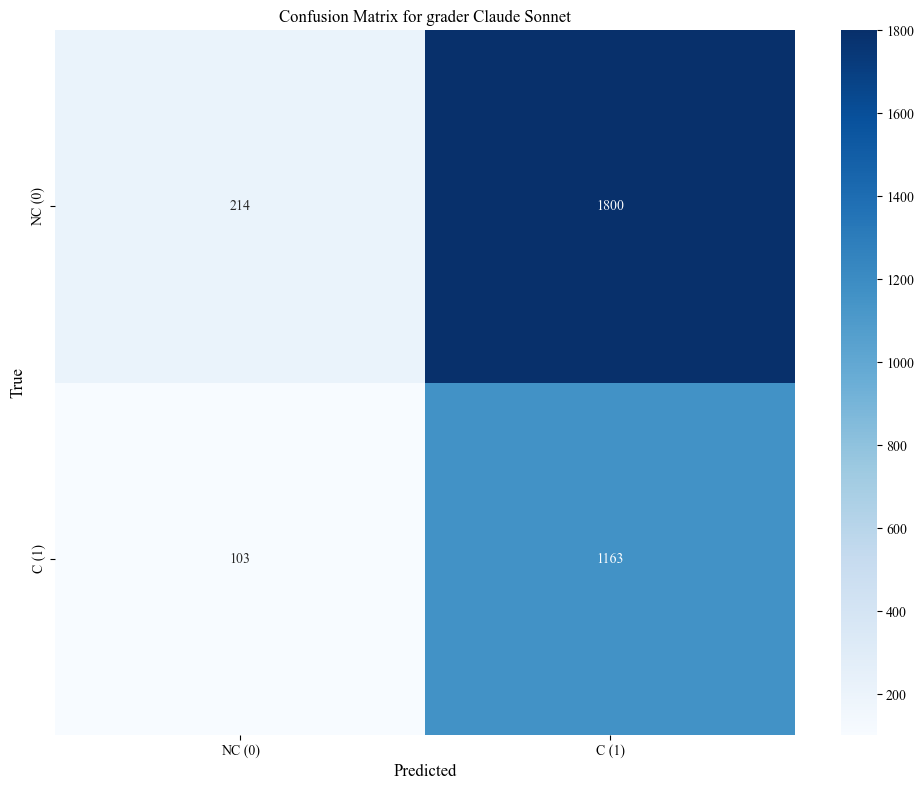


Confusion Matrix for Claude Sonnet:
[[ 214 1800]
 [ 103 1163]]
True Negatives (NC predicted as NC): 214
False Positives (NC predicted as C): 1800
False Negatives (C predicted as NC): 103
True Positives (C predicted as C): 1163


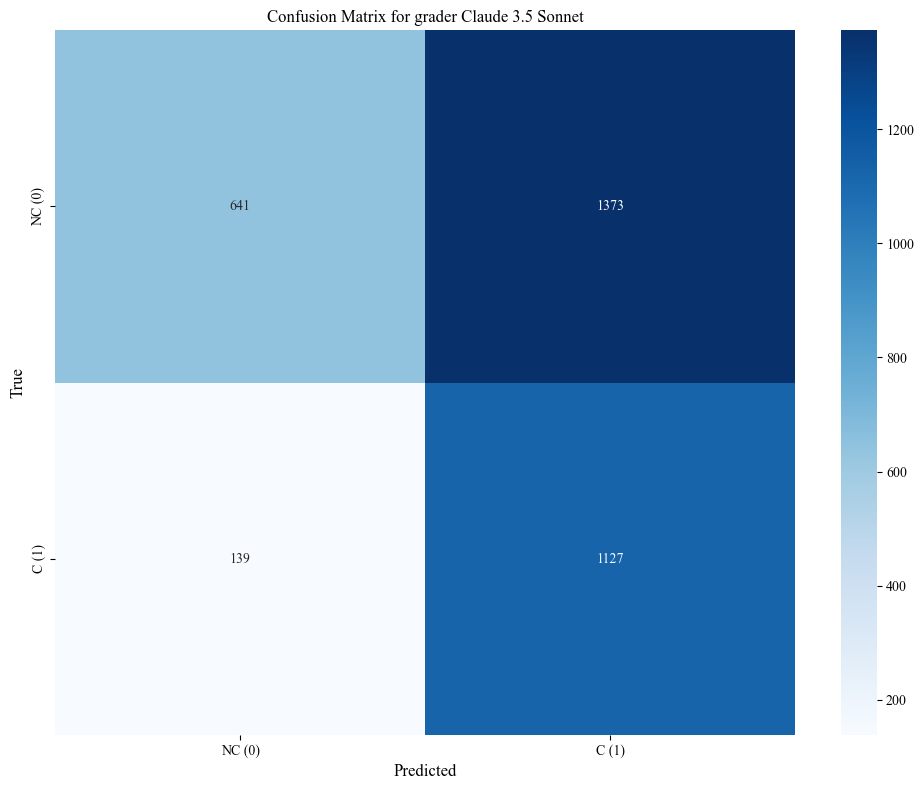


Confusion Matrix for Claude 3.5 Sonnet:
[[ 641 1373]
 [ 139 1127]]
True Negatives (NC predicted as NC): 641
False Positives (NC predicted as C): 1373
False Negatives (C predicted as NC): 139
True Positives (C predicted as C): 1127


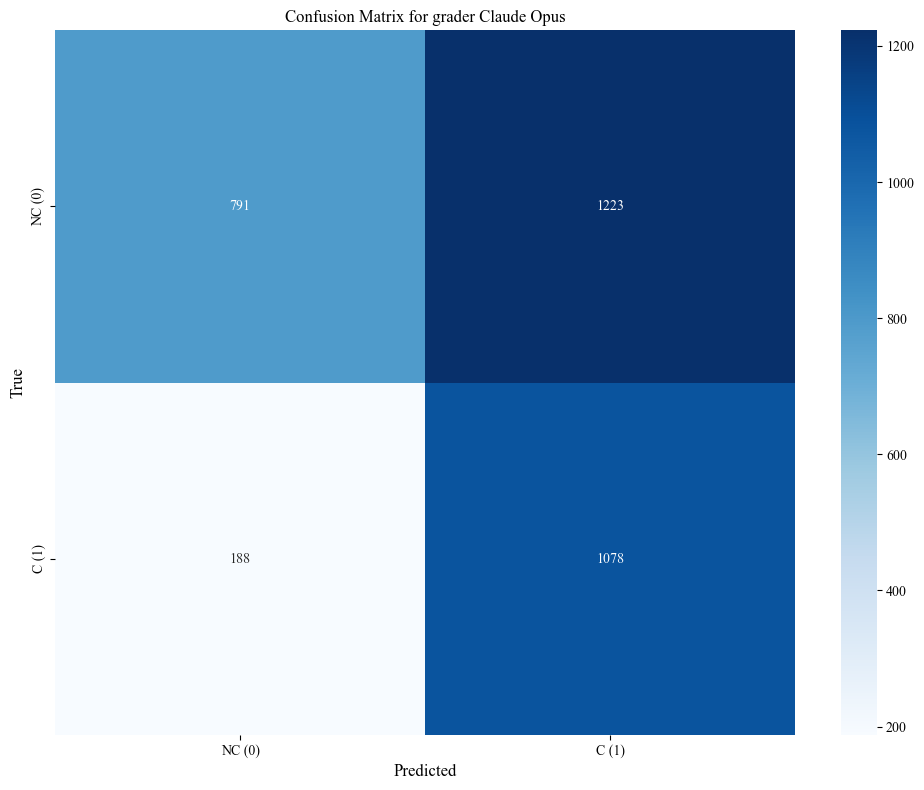


Confusion Matrix for Claude Opus:
[[ 791 1223]
 [ 188 1078]]
True Negatives (NC predicted as NC): 791
False Positives (NC predicted as C): 1223
False Negatives (C predicted as NC): 188
True Positives (C predicted as C): 1078


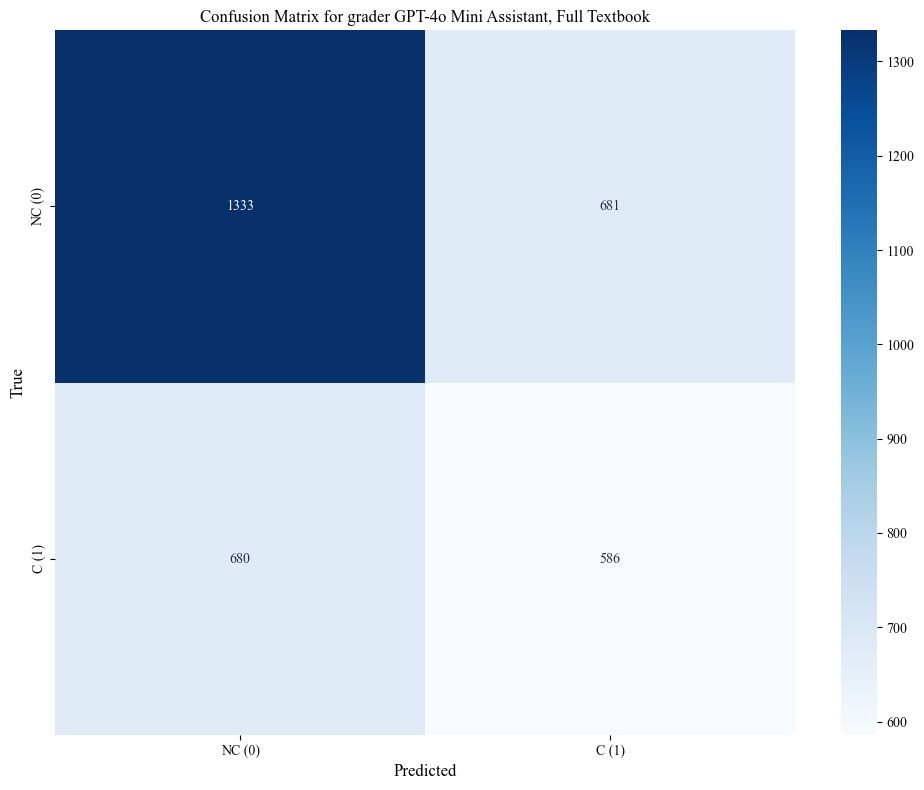


Confusion Matrix for GPT-4o Mini Assistant, Full Textbook:
[[1333  681]
 [ 680  586]]
True Negatives (NC predicted as NC): 1333
False Positives (NC predicted as C): 681
False Negatives (C predicted as NC): 680
True Positives (C predicted as C): 586


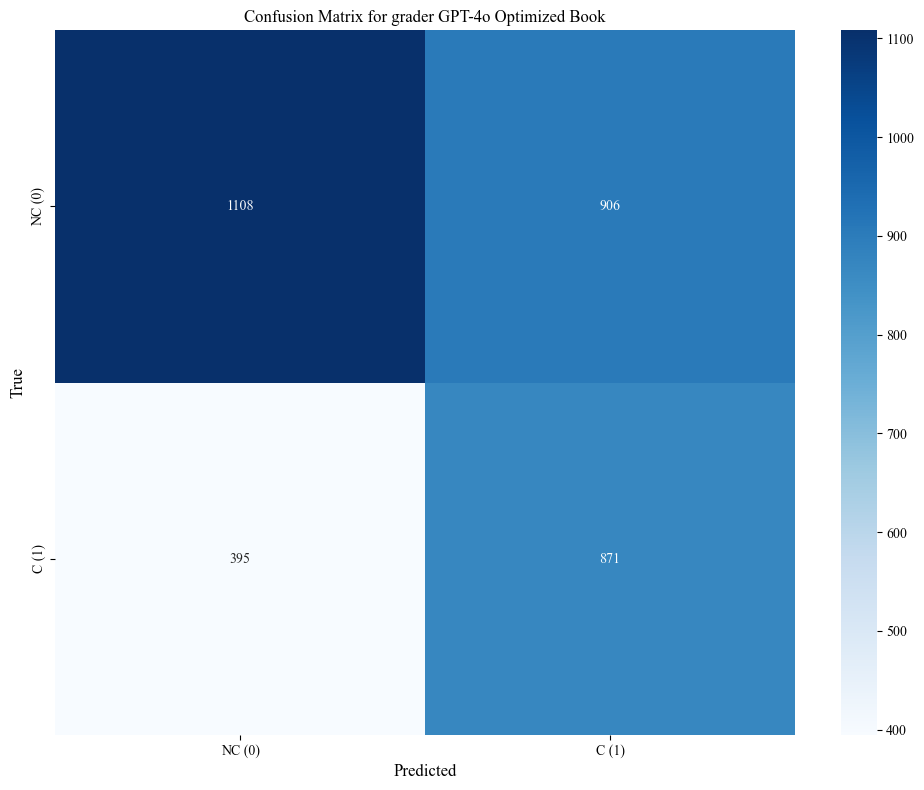


Confusion Matrix for GPT-4o Optimized Book:
[[1108  906]
 [ 395  871]]
True Negatives (NC predicted as NC): 1108
False Positives (NC predicted as C): 906
False Negatives (C predicted as NC): 395
True Positives (C predicted as C): 871


In [13]:
def extract_prediction(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'Prediction:\s*(True|False)', str(text))
    return 1 if match and match.group(1) == 'True' else 0

def create_confusion_matrix(true_labels, pred_labels):
    # Remove any rows with NaN values
    mask = ~(np.isnan(true_labels) | np.isnan(pred_labels))
    true_labels, pred_labels = true_labels[mask], pred_labels[mask]
    return confusion_matrix(true_labels, pred_labels, labels=[0, 1])

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NC (0)', 'C (1)'], yticklabels=['NC (0)', 'C (1)'])
    plt.title(f'Confusion Matrix for grader {model_name}')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png', dpi=300)
    plt.show()

# Convert 'response correct?' to integers
true_labels = models_df['response correct?'].map({'NC': 0, 'C': 1})

# Create confusion matrices for each model
for col in assess_df.columns:
    pred_labels = assess_df[col].apply(extract_prediction)
    cm = create_confusion_matrix(true_labels, pred_labels)
    
    # Use the readable name for the plot title and filename
    readable_name = readable_names.get(col, col)
    plot_confusion_matrix(cm, readable_name)
    
    print(f"\nConfusion Matrix for {readable_name}:")
    print(cm)
    print(f"True Negatives (NC predicted as NC): {cm[0, 0]}")
    print(f"False Positives (NC predicted as C): {cm[0, 1]}")
    print(f"False Negatives (C predicted as NC): {cm[1, 0]}")
    print(f"True Positives (C predicted as C): {cm[1, 1]}")

In [14]:
assess_df.isna().count()

assessment_35turbo                    3300
assessment_4omini                     3300
assessment_4o                         3300
assessment_4o_hightemp                3300
assessment_4o_lowtemp                 3300
haiku_assessment                      3300
sonnet_assessment                     3300
sonnet35_assessment                   3300
opus_assessment                       3300
gpt_assis_4omini_assessment           3300
gpt_assis_optimizedbook_assessment    3300
dtype: int64

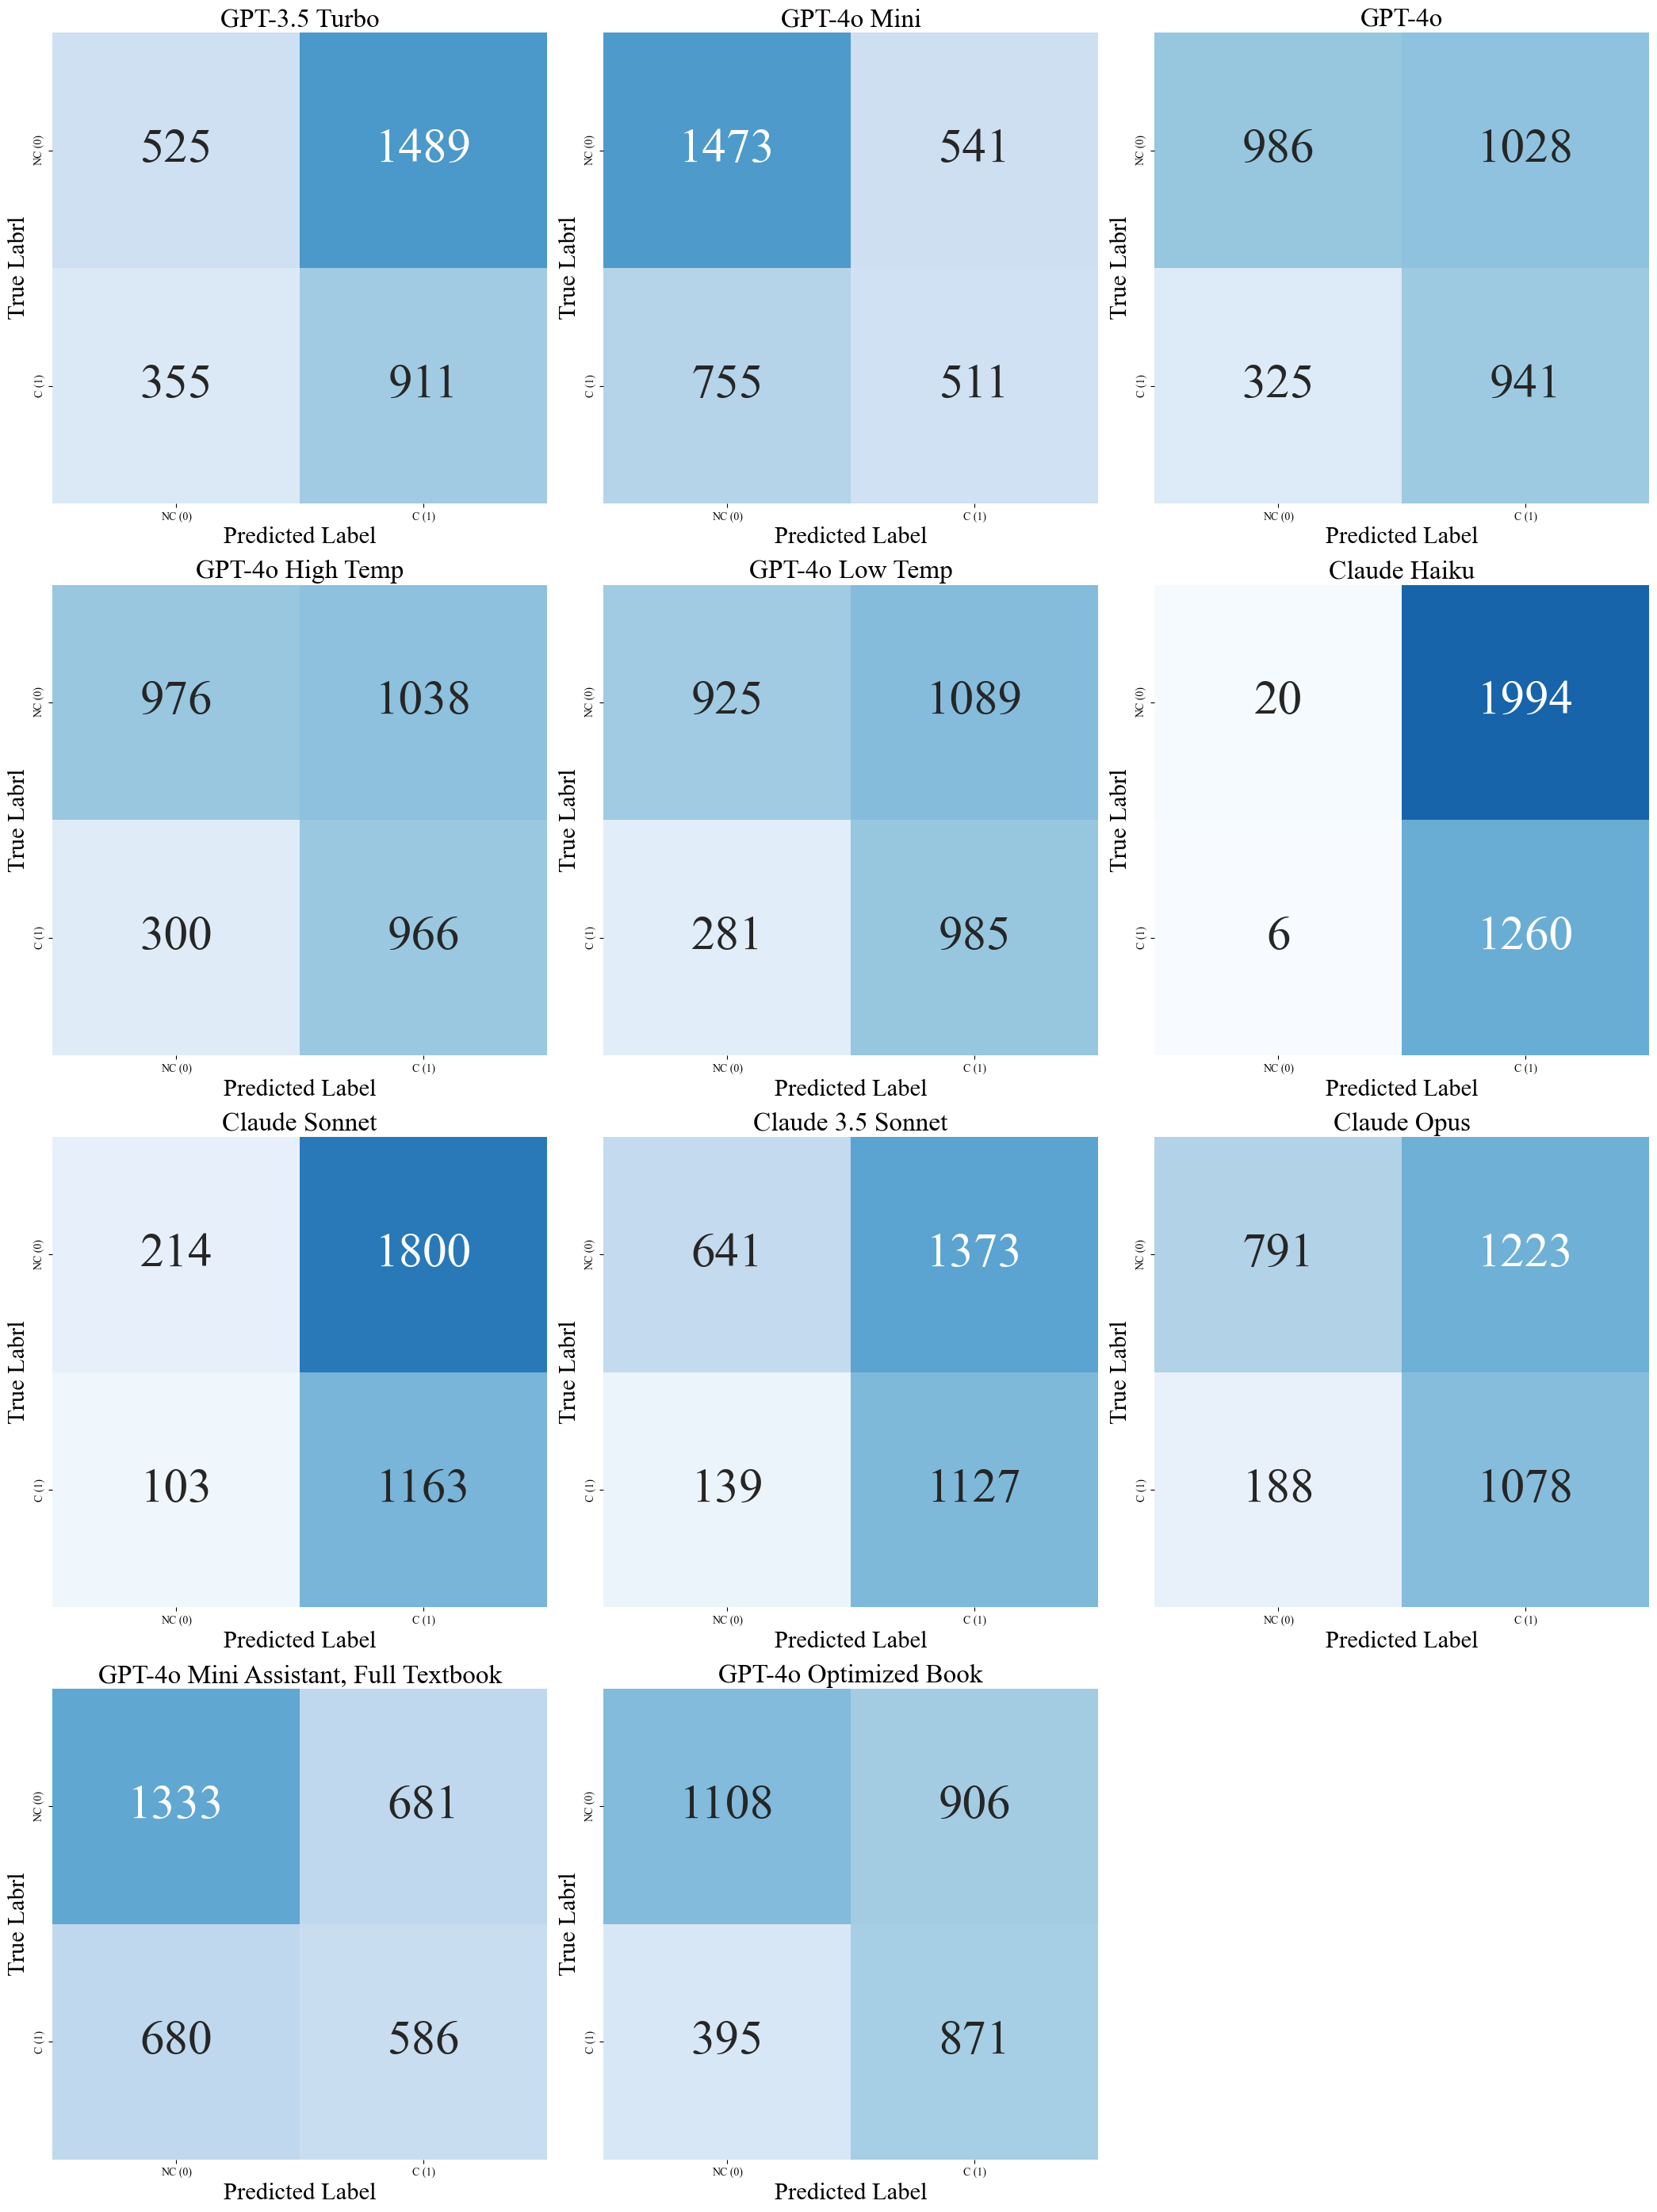


Metrics for GPT-3.5 Turbo:
----------------------------------------
True Negatives (NC predicted as NC): 525
False Positives (NC predicted as C): 1489
False Negatives (C predicted as NC): 355
True Positives (C predicted as C): 911
Accuracy: 43.78%
----------------------------------------

Metrics for GPT-4o Mini:
----------------------------------------
True Negatives (NC predicted as NC): 1473
False Positives (NC predicted as C): 541
False Negatives (C predicted as NC): 755
True Positives (C predicted as C): 511
Accuracy: 60.49%
----------------------------------------

Metrics for GPT-4o:
----------------------------------------
True Negatives (NC predicted as NC): 986
False Positives (NC predicted as C): 1028
False Negatives (C predicted as NC): 325
True Positives (C predicted as C): 941
Accuracy: 58.75%
----------------------------------------

Metrics for GPT-4o High Temp:
----------------------------------------
True Negatives (NC predicted as NC): 976
False Positives (NC predic

In [15]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from math import ceil

# Section 1: Data Extraction
def extract_prediction(text):
    """
    Extracts binary prediction from text response.
    Returns NaN for non-matching texts (rare cases where text format differs).
    """
    if pd.isna(text):
        return np.nan
    match = re.search(r'Prediction:\s*(True|False)', str(text))
    return 1 if match and match.group(1) == 'True' else 0

# Section 2: Confusion Matrix Creation
def create_confusion_matrix(true_labels, pred_labels):
    """
    Creates confusion matrix after handling NaN values.
    NaN values occur in rare cases where text responses don't match expected format. This was rather rare.
    """
    mask = ~(np.isnan(true_labels) | np.isnan(pred_labels))
    true_labels, pred_labels = true_labels[mask], pred_labels[mask]
    return confusion_matrix(true_labels, pred_labels, labels=[0, 1])

# Section 3: Grid Visualization
def plot_confusion_matrices_grid(matrices_info):
    """
    Creates a grid of confusion matrices.
    matrices_info: list of tuples (confusion_matrix, model_name)
    """
    n_matrices = len(matrices_info)
    n_cols = min(3, n_matrices)  # Maximum 3 columns
    n_rows = ceil(n_matrices / n_cols)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(7*n_cols, 7*n_rows))
    
    for idx, (cm, model_name) in enumerate(matrices_info, 1):
        plt.subplot(n_rows, n_cols, idx)
        
        # Plot individual confusion matrix
        sns.heatmap(cm,
                   annot=True,
                   fmt='d',
                   cmap='Blues',
                   xticklabels=['NC (0)', 'C (1)'],
                   yticklabels=['NC (0)', 'C (1)'],
                   annot_kws={'size': 44},
                   vmin=0,
                   vmax=2500,
                   cbar=False)  # Removed color bar
        
        plt.xlabel('Predicted Label', fontsize=22)
        plt.ylabel('True Labrl', fontsize=22)
        plt.title(model_name, fontsize=24, pad=6)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary metrics
    for cm, model_name in matrices_info:
        print(f"\nMetrics for {model_name}:")
        print("-" * 40)
        print(f"True Negatives (NC predicted as NC): {cm[0, 0]}")
        print(f"False Positives (NC predicted as C): {cm[0, 1]}")
        print(f"False Negatives (C predicted as NC): {cm[1, 0]}")
        print(f"True Positives (C predicted as C): {cm[1, 1]}")
        
        total = np.sum(cm)
        correct = cm[0, 0] + cm[1, 1]
        print(f"Accuracy: {correct/total:.2%}")
        print("-" * 40)

# Execute the analysis
if __name__ == "__main__":
    # Convert 'response correct?' to integers
    true_labels = models_df['response correct?'].map({'NC': 0, 'C': 1})
    
    # Create list to store confusion matrices and model names
    matrices_info = []
    
    # Generate confusion matrices for each model
    for col in assess_df.columns:
        pred_labels = assess_df[col].apply(extract_prediction)
        cm = create_confusion_matrix(true_labels, pred_labels)
        readable_name = readable_names.get(col, col)
        matrices_info.append((cm, readable_name))
    
    # Create grid visualization
    plot_confusion_matrices_grid(matrices_info)

In [16]:
## cost analysis

import pandas as pd

prices_df = {
    "Model": [
        "claude-3-5-sonnet-20240620", 
        "claude-3-haiku-20100307", 
        "claude-3-opus-20240229", 
        "claude-3-sonnet-20240229", 
        "got-4o-assistant-optimizedbook", 
        "got-4o-mini-assistant-fullbook", 
        "gpt-3.5-turbo", 
        "gpt-4o", 
        "gpt-4o-mini", 
        "gpt-4o_hightemp", 
        "gpt-4o_lowtemp"
    ],
    "Correct Rate": [
        0.333333, 0.197324, 0.486577, 0.256667, 0.584459, 0.446367, 0.302013, 
        0.390000, 0.350000, 0.433333, 0.470000
    ],
    "Conf Matrix Accuracy": [
        53.90, 39.02, 56.98, 41.98, 60.34, 58.51, 43.78, 58.75, 60.49, 59.21, 58.23
    ],
    "Input Cost per Million Tokens": [
        3.00, 0.25, 15.00, 3.00, 2.50, 0.15, 1.50, 2.50, 0.15, 2.50, 2.50
    ],
    "Output Cost per Million Tokens": [
        15.00, 1.25, 75.00, 15.00, 10.00, 0.60, 2.00, 10.00, 0.60, 10.00, 10.00
    ]
}

prices_df = pd.DataFrame(prices_df)
prices_df



,Model,Correct Rate,Conf Matrix Accuracy,Input Cost per Million Tokens,Output Cost per Million Tokens
0,claude-3-5-sonnet-20240620,0.333333,53.90,3.00,15.00
1,claude-3-haiku-20100307,0.197324,39.02,0.25,1.25
2,claude-3-opus-20240229,0.486577,56.98,15.00,75.00
3,claude-3-sonnet-20240229,0.256667,41.98,3.00,15.00
4,got-4o-assistant-optimizedbook,0.584459,60.34,2.50,10.00
5,got-4o-mini-assistant-fullbook,0.446367,58.51,0.15,0.60
6,gpt-3.5-turbo,0.302013,43.78,1.50,2.00
7,gpt-4o,0.390000,58.75,2.50,10.00
8,gpt-4o-mini,0.350000,60.49,0.15,0.60
9,gpt-4o_hightemp,0.433333,59.21,2.50,10.00


C:\Users\mxgre\AppData\Local\Temp\ipykernel_10068\3617069625.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, orientation='vertical', aspect=30, label="Correct Rate Solving Integrals")


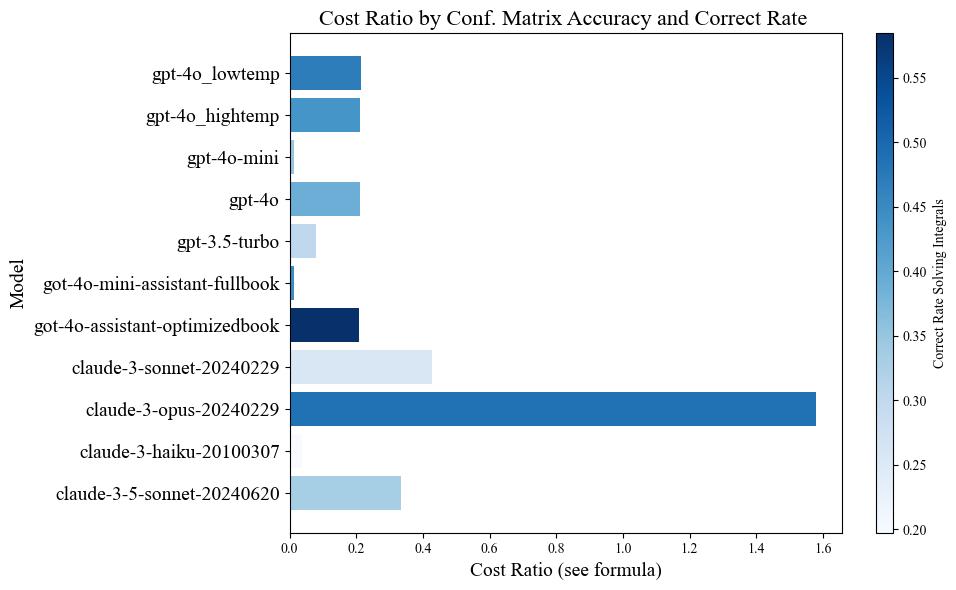

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# formula 
prices_df["Cost per Correct"] = (
    prices_df["Input Cost per Million Tokens"] + prices_df["Output Cost per Million Tokens"]
) / (prices_df["Correct Rate"]*(1/11) + prices_df["Conf Matrix Accuracy"])


plt.figure(figsize=(10, 6))
norm = plt.Normalize(prices_df["Correct Rate"].min(), prices_df["Correct Rate"].max())  # changed
plt.barh(prices_df["Model"], prices_df["Cost per Correct"], color=plt.colormaps["Blues"](norm(prices_df["Correct Rate"])))  # changed
plt.xlabel("Cost Ratio (see formula)", fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.title("Cost Ratio by Conf. Matrix Accuracy and Correct Rate ", fontsize=16)

sm = plt.cm.ScalarMappable(cmap=plt.colormaps["Blues"], norm=norm) 
sm.set_array([])  # changed
plt.colorbar(sm, orientation='vertical', aspect=30, label="Correct Rate Solving Integrals") 

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Create or reuse your merged `plot_df` that has:
#    ['Model', 'Input Cost per Million Tokens', 'Output Cost per Million Tokens',
#     'accuracy', 'correct_rate']

# Example: define total cost and ratio columns
plot_df['total_cost'] = plot_df['Input Cost per Million Tokens'] + plot_df['Output Cost per Million Tokens']
plot_df['accuracy_to_cost'] = plot_df['accuracy'] / plot_df['total_cost']  # efficacy = accuracy / cost
plot_df['correct_to_cost'] = plot_df['correct_rate'] / plot_df['total_cost']

def plot_overlay_cost_accuracy_correctness(plot_df):
    """
    Creates a single figure that overlays:
      - Bars for total cost (left Y-axis).
      - Lines for accuracy, correctness rate, and accuracy/cost ratio (right Y-axis).
    """
    x = np.arange(len(plot_df))
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # --- Bars for cost (left axis)
    bar_width = 0.6
    bars = ax1.bar(
        x, plot_df['total_cost'],
        width=bar_width,
        color='lightgray',
        label='Total Cost'
    )
    ax1.set_ylabel('Cost per Million Tokens', fontsize=12)
    ax1.set_ylim(0, plot_df['total_cost'].max() * 1.25)
    ax1.set_xticks(x)
    ax1.set_xticklabels(plot_df['Model'], rotation=45, ha='right')
    
    # --- Lines for accuracy/correctness/ratio (right axis)
    ax2 = ax1.twinx()
    
    line1, = ax2.plot(
        x, plot_df['accuracy'], color='blue', marker='o', label='Accuracy'
    )
    line2, = ax2.plot(
        x, plot_df['correct_rate'], color='green', marker='D', label='Correctness'
    )
    line3, = ax2.plot(
        x, plot_df['accuracy_to_cost'], color='orange', marker='s', label='Acc/Cost Ratio'
    )
    # (Optionally you could also plot correct_to_cost)
    # line4, = ax2.plot(
    #     x, plot_df['correct_to_cost'], color='red', marker='^', label='Correct/Cost Ratio'
    # )
    
    ax2.set_ylabel('Accuracy / Correctness / Ratio', fontsize=12)
    ax2.set_ylim(0, max(
        plot_df['accuracy'].max(), 
        plot_df['correct_rate'].max(),
        plot_df['accuracy_to_cost'].max()
    ) * 1.2)
    
    # Combine legends
    lines_for_legend = [bars, line1, line2, line3]  # or add line4 if you include it
    labels_for_legend = [bar.get_label() for bar in [bars]] + [l.get_label() for l in [line1, line2, line3]]
    ax1.legend(lines_for_legend, labels_for_legend, loc='upper left', fontsize=11)
    
    ax1.set_title('Overlay of Cost, Accuracy, Correctness, and Price-to-Efficacy Ratios', fontsize=15)
    fig.tight_layout()
    plt.show()

# Finally, call the function:
plot_overlay_cost_accuracy_correctness(plot_df)


In [ ]:
def detect_pattern(text):
    pattern = r"^(C|NC)$"
    return bool(re.match(pattern, str(text)))

# Assuming models_df is your dataframe
column_to_check = "response correct?"

# Create a new series with boolean values indicating if the pattern was not found
pattern_not_found = models_df[column_to_check].apply(lambda x: not detect_pattern(x))

# Convert the series to a dataframe for heatmap plotting
pattern_not_found_df = pd.DataFrame(pattern_not_found)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pattern_not_found_df, cmap='YlOrRd', cbar_kws={'label': 'Pattern Not Found'})
plt.title('Heatmap of Rows Where Pattern Was Not Detected in "response correct?" Column')
plt.xlabel('Row Index')
plt.tight_layout()
plt.show()

# Spot Checking Quality of Final Assessment Code

Checking 25 solutions by hand.

In [7]:
byhandcheck = models_df[['question','response','mit_provided_solution','response correct?']].sample(n=25)

In [8]:
byhandcheck.to_csv('random_25_samples.csv')

The row numbers and questions checked:

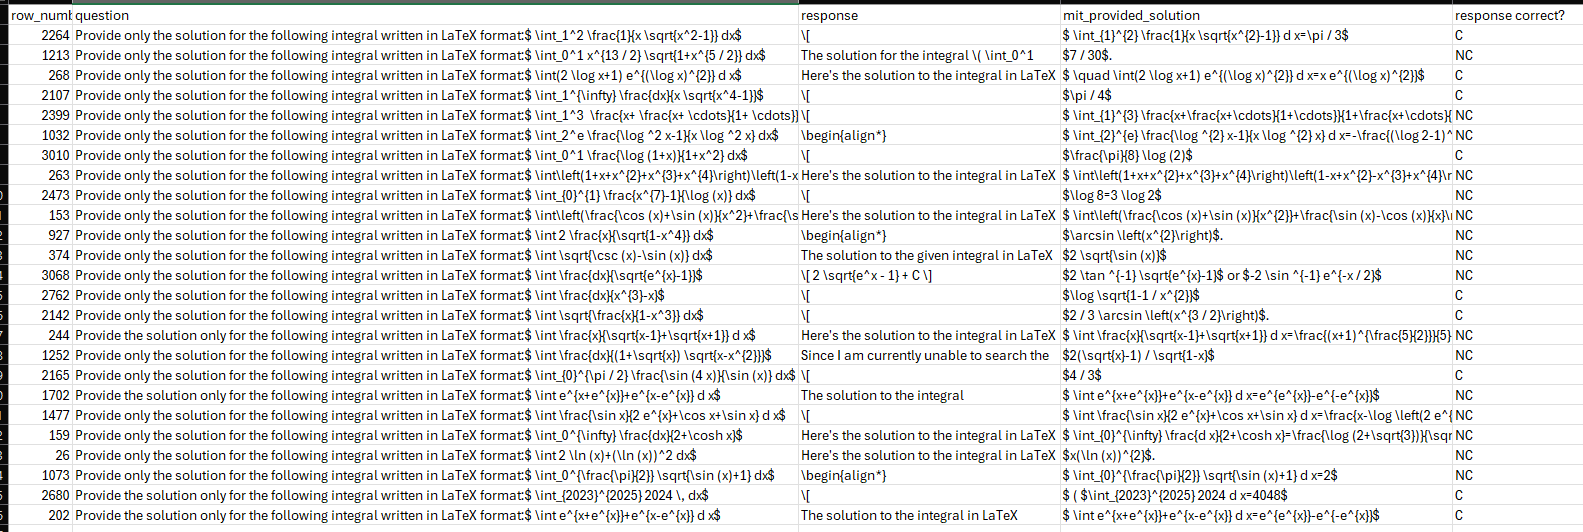

row flagged: 2762. It appears there is some issue with the key solution, as the 'response' seems to be a more valid answer to the selected integral.

row flaggged: 2165. There appears to be a similar disagreement between the key and the solution. The correctly labelled solution was '2'. The key provides '4/3'.

All other rows validate successfully. 

25 rows validated:

- 2264
- 1213
- 268
- 2107
- 2399
- 1032
- 3010
- 263
- 2473
- 153
- 927
- 374
- 3068
- 2762
- 2142
- 244
- 1252
- 2165
- 1702
- 1477
- 159
- 26
- 1073
- 2680
- 202



### End of file